# CheXpert Dataset Preprocessing

In [ ]:
!pip install barbar

import numpy as np
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
from PIL import Image
from barbar import Bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

import albumentations as A
from albumentations.augmentations.transforms import CLAHE
from albumentations.pytorch.transforms import ToTensorV2

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CheXpert_Small/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: CheXpert-v1.0-small/train/patient60445/study2/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60445/study2/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60446/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60446/study2/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60446/study2/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60447/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60447/study1/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60448/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60448/study1/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60448/study1/view3_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60449/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60449/study1/view2_lateral.jpg  
 

In [ ]:
# specify unwanted columns
columns_to_drop = ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Atelectasis', 'Pneumothorax', 'Pleural Other', 'Fracture', 'Support Devices']

Traindata = pd.read_csv('CheXpert-v1.0-small/train.csv') # read train.csv
Traindata = Traindata.drop(columns=columns_to_drop) # Getting rid of everything except the 3 diseases that we need
Traindata = Traindata[Traindata['Path'].str.contains("frontal")] # use only frontal images
Traindata = Traindata[500:] # data 500 to the end
Traindata.to_csv('./CheXpert-v1.0-small/train_mod.csv', index = False) #Convert to CSV
print("Train data length:", len(Traindata))
print(Traindata)

Validdata = pd.read_csv('./CheXpert-v1.0-small/valid.csv') # read valid.csv
Validdata = Validdata.drop(columns=columns_to_drop) # Getting rid of everything except the 3 diseases that we need
Validdata = Validdata[Validdata['Path'].str.contains("frontal")] # use only frontal images
Validdata.to_csv('./CheXpert-v1.0-small/valid_mod.csv', index = False) #Convert to CSV
print("Valid data length:", len(Validdata))

Testdata = Traindata[:500] # train data is 500 to the end
Testdata.to_csv('./CheXpert-v1.0-small/test_mod.csv', index = False) #Convert to CSV
print("Test data length:", len(Testdata))

pathFileTrain = './CheXpert-v1.0-small/train_mod.csv'
pathFileValid = './CheXpert-v1.0-small/valid_mod.csv'
pathFileTest = './CheXpert-v1.0-small/test_mod.csv'

nnIsTrained = False     # Not pre-trained
nnClassCount = 4        # Dimension of the output (pleural effusion, cardiomegaly, pneumonia, nothing)

trBatchSize = 16        # Batch size
trMaxEpoch = 3          # Epoch

# Image transformation here
imgtransResize = (320, 320)
imgtransCrop = 250
gamma_value = 1.0

class_names = ['Cardiomegaly', 'Pneumonia', 'Pleural Effusion', 'Nothing']

Train data length: 190527
                                                     Path  Cardiomegaly  \
621     CheXpert-v1.0-small/train/patient00147/study13...           NaN   
622     CheXpert-v1.0-small/train/patient00147/study8/...           NaN   
623     CheXpert-v1.0-small/train/patient00147/study14...           NaN   
624     CheXpert-v1.0-small/train/patient00147/study10...           NaN   
625     CheXpert-v1.0-small/train/patient00147/study9/...           NaN   
...                                                   ...           ...   
223409  CheXpert-v1.0-small/train/patient64537/study2/...           NaN   
223410  CheXpert-v1.0-small/train/patient64537/study1/...           NaN   
223411  CheXpert-v1.0-small/train/patient64538/study1/...           NaN   
223412  CheXpert-v1.0-small/train/patient64539/study1/...           1.0   
223413  CheXpert-v1.0-small/train/patient64540/study1/...           NaN   

        Pneumonia  Pleural Effusion  
621           NaN               1.0

## Create Dataset

In [ ]:
class CheXpertDataSet(Dataset):
    def __init__(self, data_PATH, transform = None, policy = "ones", gamma=1.0, apply_clahe=False):
      image_names = []
      labels = []
      with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None) # skip the header
            for line in csvReader:
              image_name = line[0]
              label = line[1:] + [0]

              for i in range(4):
                if i == 3:
                  if label[0] == 1 or label[1] == 1 or label[2] == 1:
                    label[i] = 0
                  else:
                    label[i] = 1
                else:
                  if label[i]:
                    a = float(label[i])
                    if a == 1:
                      label[i] = 1
                    elif a == -1:
                      if policy == "ones":
                        label[i] = 1
                      elif policy == "zeroes":
                        label[i] = 0
                      else:
                        label[i] = 0
                    else:
                      label[i] = 0
                  else:
                    label[i] = 0

              image_names.append('./' + image_name)
              labels.append(label)

      self.image_names = image_names
      self.labels = labels
      self.transform = transform

    def __getitem__(self, index):
      """Take the index of item and returns the image and its labels"""
      image_name = self.image_names[index]
      image = Image.open(image_name).convert('RGB')

      # Apply gamma correction
      if hasattr(self, 'gamma') and self.gamma != 1.0:
        image = np.array(image)
        image = gamma_correction(image, gamma=self.gamma)
        image = Image.fromarray(image)

      # Apply CLAHE
      if hasattr(self, 'apply_clahe') and self.apply_clahe:
        image = np.array(image)
        image = apply_clahe(image)
        image = Image.fromarray(image)

      label = self.labels[index]
      if self.transform is not None:
        image = self.transform(image)
      return image, torch.FloatTensor(label)

    def __len__(self):
      return len(self.image_names)

## Preprocessing

### Contrast Limited Adaptive histogram equalization

In [ ]:
def apply_clahe(image, clip_limit=8.0, tile_grid_size=(4, 4), p=1.0, alpha=0):
    clahe_transform = CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True, p=p)
    augmented = clahe_transform(image=image)
    final_img = augmented['image'] + alpha
    return final_img

### Gamma Correction

In [ ]:
def gamma_correction(image, gamma=1.0):
    """Applies gamma correction to a given image using the specified gamma value.

    Args:
        image (numpy.ndarray): The input image to be corrected.
        gamma (float): The gamma value to use for correction. Default is 1.0 (no correction applied).

    Returns:
        numpy.ndarray: The gamma-corrected image.
    """
    # Ensure gamma is non-negative
    if gamma < 0:
        raise ValueError("Gamma value should be non-negative.")

    # Normalize the image to the [0, 1] range

    normalized_image = image.astype(np.float32) / 255.0

    # Apply gamma correction
    corrected_image = np.power(normalized_image, gamma)

    # Scale the image to the [0, 255] range
    corrected_image = (corrected_image * 255.0).clip(0, 255).astype(np.uint8)

    return corrected_image

class GammaCorrectionTransform:
    def __init__(self, gamma=1.0):
        self.gamma = gamma

    def __call__(self, img):
        img_array = np.array(img)
        corrected_img_array = gamma_correction(img_array, self.gamma)
        return Image.fromarray(corrected_img_array)

In [ ]:
# BELOW ARE SOME TRANSFORMATION CODES

IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization) DO NOT KNOW WHAT THIS MEANS

# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transformList = []

# add preprocessing
transformList.append(transforms.Resize(imgtransResize)) # 224
transformList.append(transforms.CenterCrop(imgtransCrop))
transformList.append(transforms.Lambda(lambda x: gamma_correction(np.array(x), gamma=gamma_value)))
#transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
#transformList.append(normalize)
transformSequence = transforms.Compose(transformList)

datasetTrain = CheXpertDataSet(pathFileTrain, transformSequence, policy = "ones", gamma=1.0, apply_clahe=True) # set apply_clahe to be False if don't want to apply
print("Train data length:", len(datasetTrain))

datasetValid = CheXpertDataSet(pathFileValid, transformSequence, gamma=1.0, apply_clahe=True) # set apply_clahe to be False if don't want to apply
print("Valid data length:", len(datasetValid))

datasetTest = CheXpertDataSet(pathFileTest, transformSequence, policy = "ones", gamma=1.0, apply_clahe=True) # set apply_clahe to be False if don't want to apply
print("Test data length:", len(datasetTest))

Train data length: 190527
Valid data length: 202
Test data length: 500


##EfficientNet

This is the consolidated model trained for 1 round, with 5 clients and 3 epochs

In [ ]:
class CheXpertTrainer():
  def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, checkpoint):
    # optimizations (1: specifies parameters to be optimized, lr: learning rate, betas: coefficients used for running averages of gradients, weight_decay: penalty for large weights)
    optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0)
    loss = torch.nn.BCELoss() # setting loss function

    if checkpoint != None and use_gpu: # loading checkpoint
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])

    # Train the network
    lossMIN = 100000
    train_start = []
    train_end = []
    for epochID in range(0, trMaxEpoch):
        train_start.append(time.time()) # training starts
        losst = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
        train_end.append(time.time()) # training ends
        lossv = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
        print("Training loss: {:.3f},".format(losst), "Valid loss: {:.3f}".format(lossv))

        if lossv < lossMIN:
            lossMIN = lossv
            torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(),
                        'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()},
                        'm-epoch_FL' + str(epochID + 1) + '.pth.tar')
            print('Epoch ' + str(epochID + 1) + ' [save] loss = ' + str(lossv))
        else:
            print('Epoch ' + str(epochID + 1) + ' [----] loss = ' + str(lossv))

    train_time = np.array(train_end) - np.array(train_start)
    print("Training time for each epoch: {} seconds".format(train_time.round(0)))
    params = model.state_dict()
    return params

  def epochTrain(model, dataLoaderTrain, optimizer, epochMax, classCount, loss):
    losstrain = 0
    model.train()

    for batchID, (varInput, target) in enumerate(Bar(dataLoaderTrain)):

        varTarget = target.cuda(non_blocking = True)
        varOutput = model(varInput)
        lossvalue = loss(varOutput, varTarget)

        optimizer.zero_grad()
        lossvalue.backward()
        optimizer.step()

        losstrain += lossvalue.item()

    return losstrain / len(dataLoaderTrain)

  def epochTrain(model, dataLoaderTrain, optimizer, epochMax, classCount, loss):
    losstrain = 0
    model.train()

    for batchID, (varInput, target) in enumerate(Bar(dataLoaderTrain)):

        varTarget = target.cuda(non_blocking = True)
        varOutput = model(varInput)
        lossvalue = loss(varOutput, varTarget)

        optimizer.zero_grad()
        lossvalue.backward()
        optimizer.step()

        losstrain += lossvalue.item()

    return losstrain / len(dataLoaderTrain)

  def epochVal(model, dataLoaderVal, optimizer, epochMax, classCount, loss):
        model.eval()
        lossVal = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):

                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)

                lossVal += loss(varOutput, target)

        return lossVal / len(dataLoaderVal)


  def computeAUROC(dataGT, dataPRED, classCount):
    # Computes area under ROC curve
    # dataGT: ground truth data
    # dataPRED: predicted data
    outAUROC = []
    datanpGT = dataGT.cpu().numpy()
    datanpPRED = dataPRED.cpu().numpy()

    for i in range(classCount):
        try:
            outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
        except ValueError:
            pass
    return outAUROC

  def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):
      cudnn.benchmark = True

      if checkpoint != None and use_gpu:
          modelCheckpoint = torch.load(checkpoint)
          model.load_state_dict(modelCheckpoint['state_dict'])

      if use_gpu:
          outGT = torch.FloatTensor().cuda()
          outPRED = torch.FloatTensor().cuda()
      else:
          outGT = torch.FloatTensor()
          outPRED = torch.FloatTensor()

      model.eval()

      with torch.no_grad():
          for i, (input, target) in enumerate(dataLoaderTest):

              target = target.cuda()
              outGT = torch.cat((outGT, target), 0).cuda()

              bs, c, h, w = input.size()
              varInput = input.view(-1, c, h, w)

              out = model(varInput)
              outPRED = torch.cat((outPRED, out), 0)
      aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
      aurocMean = np.array(aurocIndividual).mean()
      print('AUROC mean ', aurocMean)

      for i in range (0, len(aurocIndividual)):
          print(class_names[i], ' ', aurocIndividual[i])

      return outGT, outPRED

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=53cc91085de876e25f9a61ed37ef00be527156f016ef6b0e60ac172d65bb2cf2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetModel(nn.Module):
    def __init__(self, out_size, efficientnet_version='b0', pretrained=True):
        super(EfficientNetModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained(f'efficientnet-{efficientnet_version}', advprop=True)
        num_ftrs = self.efficientnet._fc.in_features
        self.efficientnet._fc = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [ ]:
# FOR MULTIPLE COMMUNICATION ROUNDS
com_round = 1
fraction = 1.0
epoch = 3
batch = 48
num_clients = 5

'''
# Divide datasetTrain_ex
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5, dataleft = random_split(datasetTrain,
                                                                                                        [100, 100, 100, 100, 100,
                                                                                                         len(datasetTrain) - 500])
'''
# Divide datasetTrain_real
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5 = random_split(datasetTrain,
                                                                                              [38106, 38106, 38105, 38105, 38105])


# Define 5 DataLoaders
dataLoaderTrain_1 = DataLoader(dataset = datasetTrain_1, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_2 = DataLoader(dataset = datasetTrain_2, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_3 = DataLoader(dataset = datasetTrain_3, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_4 = DataLoader(dataset = datasetTrain_4, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_5 = DataLoader(dataset = datasetTrain_5, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)

# Define Valid and Test DataLoaders
dataLoaderVal = DataLoader(dataset = datasetValid, batch_size = trBatchSize,
                           shuffle = False, num_workers = 2, pin_memory = True)
dataLoaderTest = DataLoader(dataset = datasetTest, num_workers = 2, pin_memory = True)

In [ ]:
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader

In [ ]:
dT = [datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5]
dLT = [dataLoaderTrain_1, dataLoaderTrain_2, dataLoaderTrain_3, dataLoaderTrain_4, dataLoaderTrain_5]

nnClassCount =  4

model = EfficientNetModel(nnClassCount).cuda()
model = torch.nn.DataParallel(model).cuda()

for i in range(com_round):
    print("[[[ Round {} Start ]]]".format(i + 1))
    params = [None] * num_clients
    sel_clients = sorted(random.sample(range(num_clients), round(num_clients * fraction)))

    print("The number of clients:", len(sel_clients))
    for j in sel_clients:
        print("<< Client {} Training Start >>".format(j + 1))
        train_valid_start = time.time()
        params[j] = CheXpertTrainer.train(model, dLT[j], dataLoaderVal, # Step 3: Perform local computations
                                          nnClassCount, trMaxEpoch = epoch, checkpoint = None)
        train_valid_end = time.time()
        client_time = round(train_valid_end - train_valid_start)
        print("<< Client {} Training End: {} seconds elapsed >>".format(j + 1, client_time))

    fidx = [idx for idx in range(len(params)) if params[idx] is not None][0]
    lidx = [idx for idx in range(len(params)) if params[idx] is not None][-1]

    for key in params[fidx]:
        weights, weightn = [], []
        for k in sel_clients:
            weights.append(params[k][key] * len(dT[k]))
            weightn.append(len(dT[k]))
        params[lidx][key] = sum(weights) / sum(weightn)

    model = EfficientNetModel(nnClassCount).cuda()
    model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(params[lidx])
    print("[[[ Round {} End ]]]".format(i + 1))

print("Global model trained")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 39.3MB/s]


Loaded pretrained weights for efficientnet-b0
[[[ Round 1 Start ]]]
The number of clients: 5
<< Client 1 Training Start >>
38106/38106: [===============================>] - ETA 12.8s
Training loss: 0.454, Valid loss: 0.423
Epoch 1 [save] loss = tensor(0.4226, device='cuda:0')
38106/38106: [===============================>] - ETA 0.4s
Training loss: 0.413, Valid loss: 0.433
Epoch 2 [----] loss = tensor(0.4326, device='cuda:0')
38106/38106: [===============================>] - ETA 0.4s
Training loss: 0.392, Valid loss: 0.427
Epoch 3 [----] loss = tensor(0.4272, device='cuda:0')
Training time for each epoch: [506. 460. 457.] seconds
<< Client 1 Training End: 1428 seconds elapsed >>
<< Client 2 Training Start >>
38106/38106: [===============================>] - ETA 0.4s
Training loss: 0.415, Valid loss: 0.430
Epoch 1 [save] loss = tensor(0.4299, device='cuda:0')
38106/38106: [===============================>] - ETA 0.4s
Training loss: 0.393, Valid loss: 0.426
Epoch 2 [save] loss = tensor(0

In [ ]:
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, None, class_names)

AUROC mean  0.8544450277802196
Cardiomegaly   0.8798989273927393
Pneumonia   0.7641587776116924
Pleural Effusion   0.90585
Nothing   0.8678724061164464


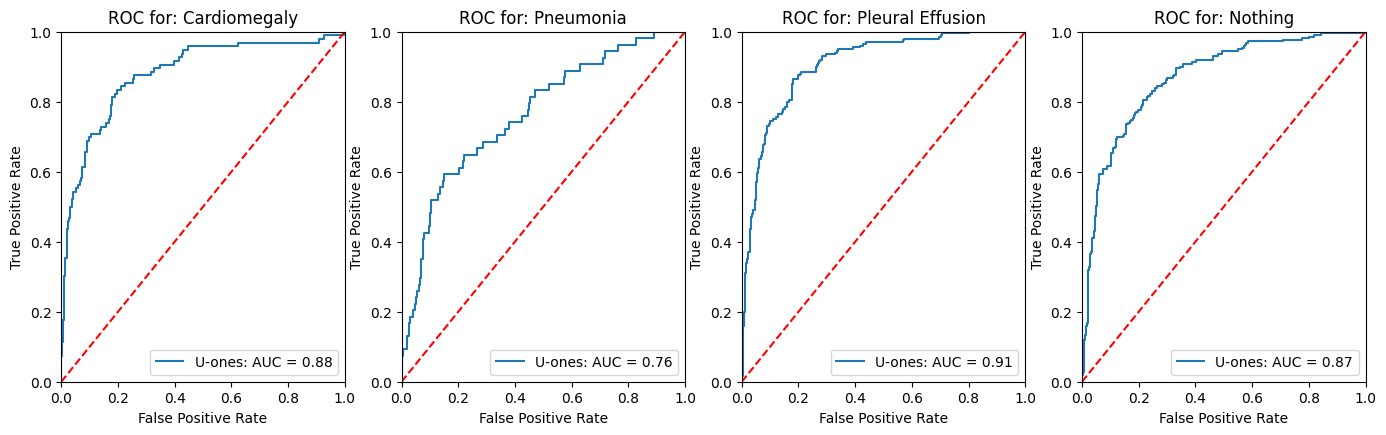

In [ ]:
for i in range(nnClassCount):
    fpr, tpr, threshold = metrics.roc_curve(outGT.cpu()[:,i], outPRED.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)

    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (300, 100)

plt.show()

<ipython-input-21-cec9d318cb7b>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (outPRED.cpu()[:, i] > 0.5).numpy().astype(np.int)
<ipython-input-21-cec9d318cb7b>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

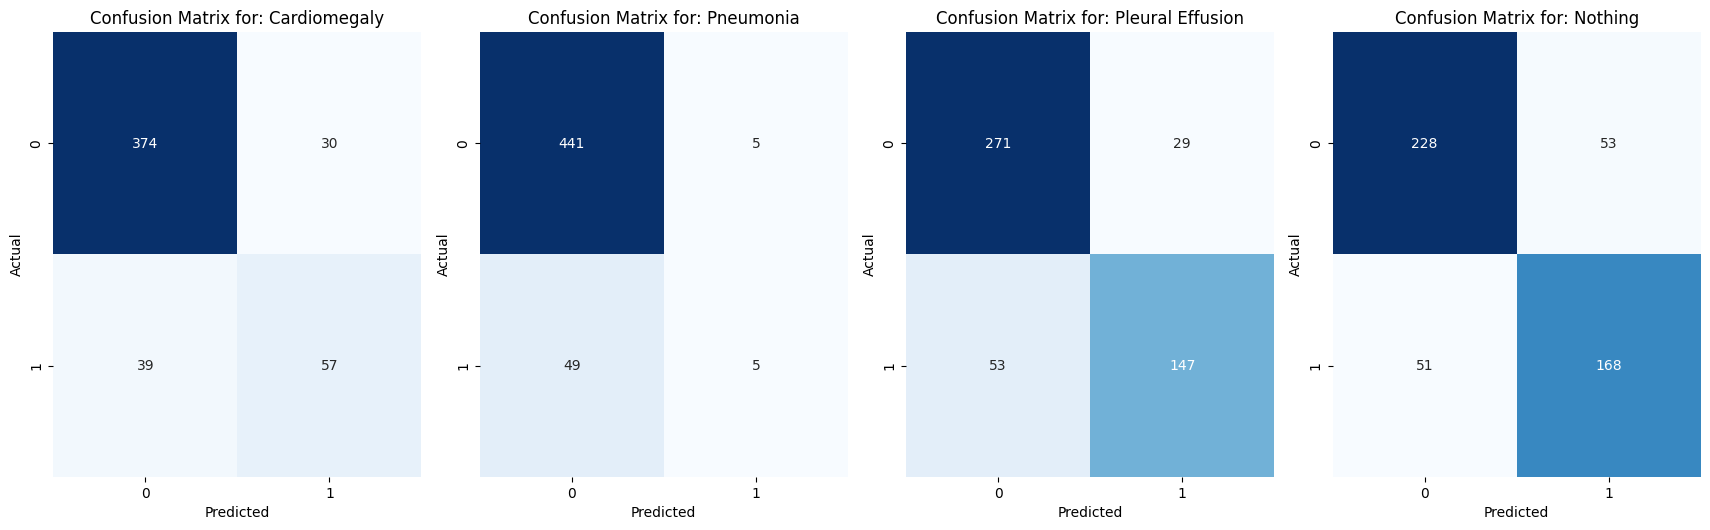

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(nnClassCount):
      y_true = outGT.cpu()[:, i]
      y_pred = (outPRED.cpu()[:, i] > 0.5).numpy().astype(np.int)
      cm = confusion_matrix(y_true, y_pred)
      f = plt.subplot(2, 7, i + 1)
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
      plt.title('Confusion Matrix for: ' + class_names[i])
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
plt.tight_layout()
plt.show()

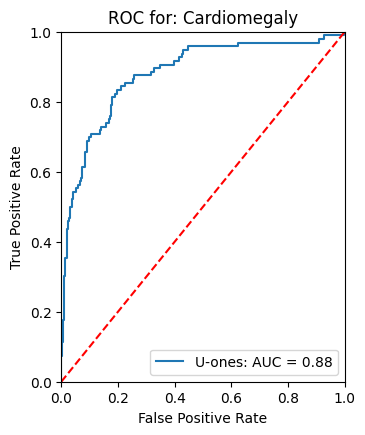

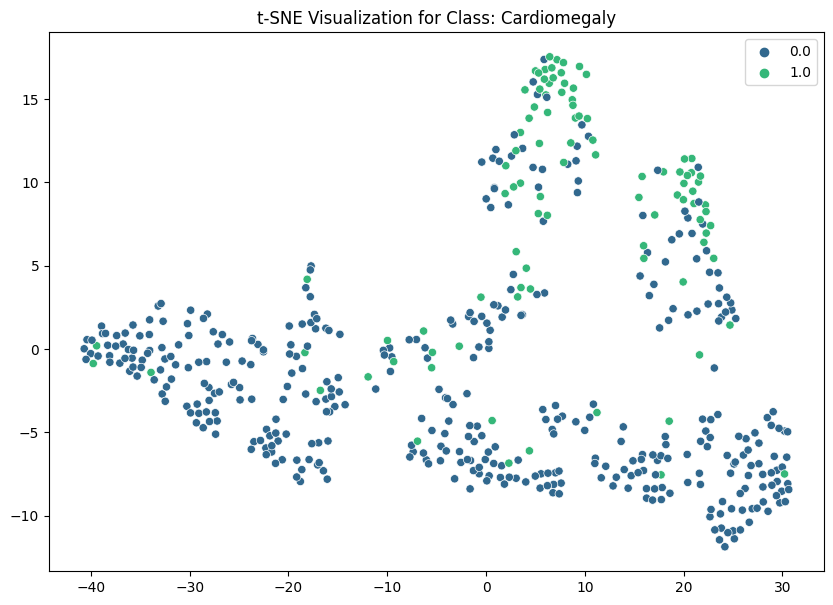

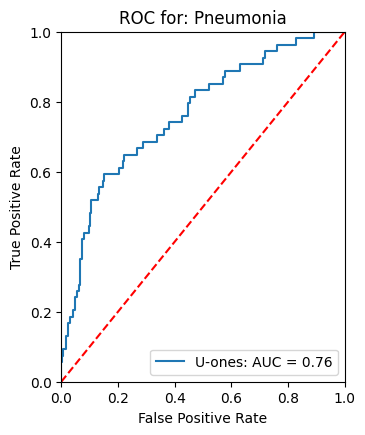

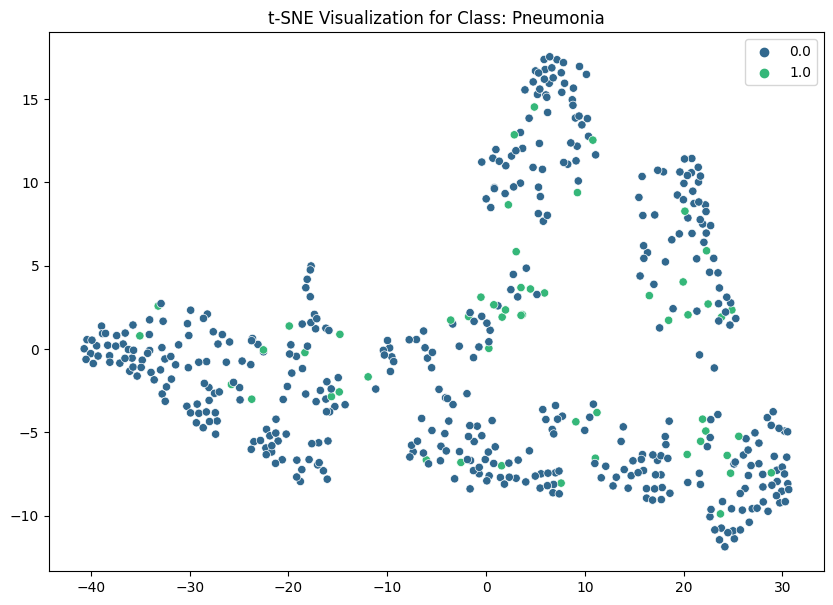

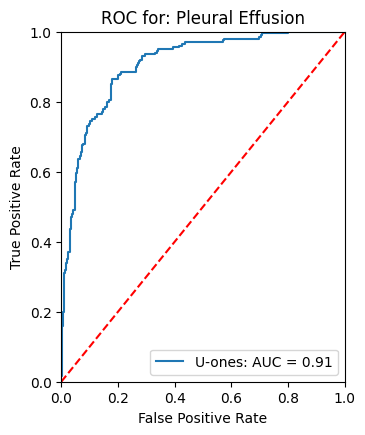

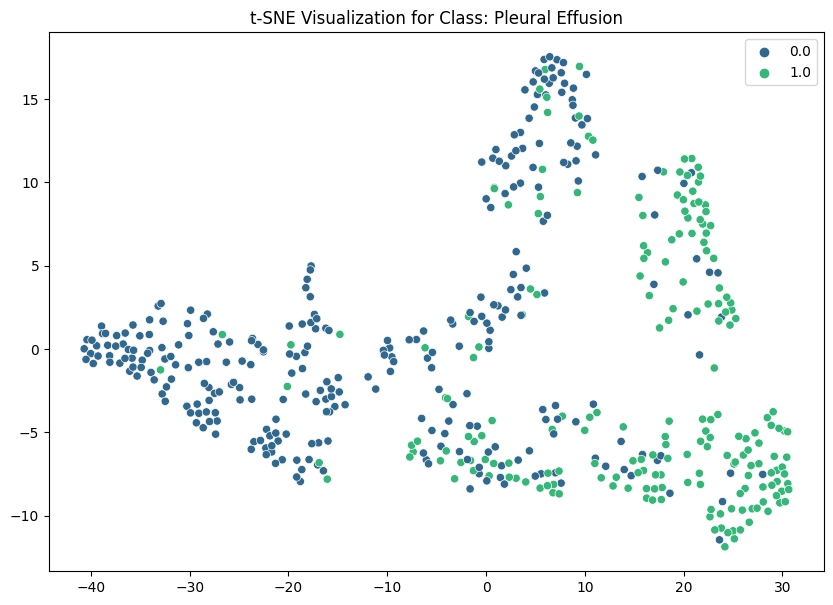

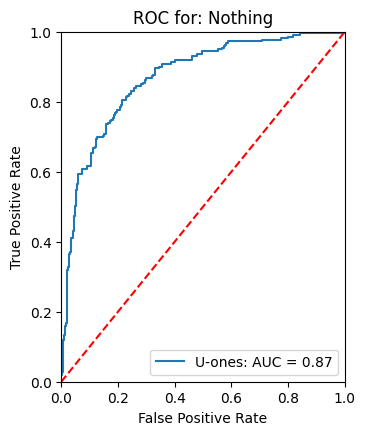

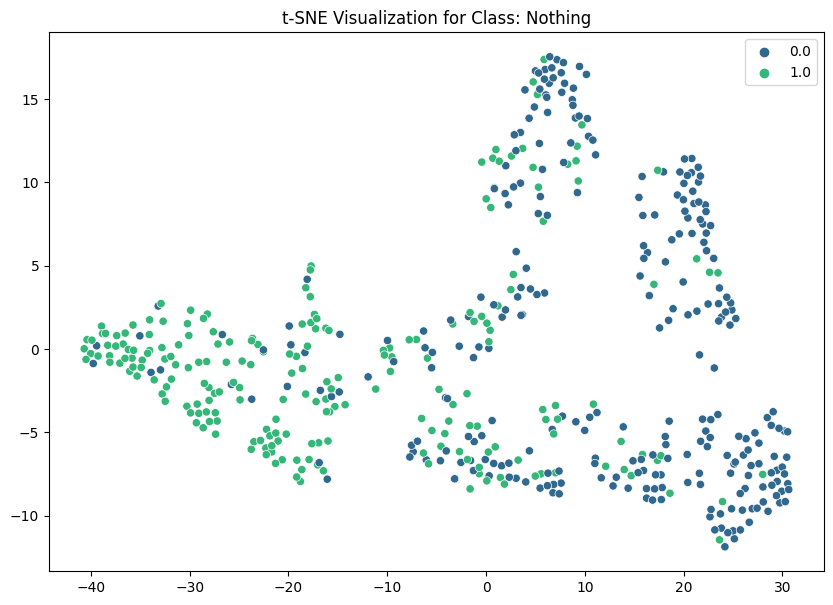

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(outPRED.cpu().numpy())

for i in range(nnClassCount):
    fpr, tpr, threshold = metrics.roc_curve(outGT.cpu()[:, i], outPRED.cpu()[:, i])
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC curve
    f = plt.subplot(2, 7, i + 1)
    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label='U-ones: AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=outGT.cpu()[:, i], palette='viridis', legend='full')
    plt.title('t-SNE Visualization for Class: ' + class_names[i])
    plt.show()